In [14]:
import xgboost
import shap
import matplotlib
import pandas as pd

# train an XGBoost model

df = pd.read_csv('df.csv')
df.columns


Index(['X.insurance', 'X.language', 'X.marital_status', 'X.los', 'X.gender',
       'X.anchor_age', 'X.race', 'X.has_type1_diabetes',
       'X.has_type2_diabetes', 'X.has_hypertension',
       'X.has_atrial_fibrillation', 'X.has_copd', 'X.has_asthma',
       'X.has_liver_disease', 'X.has_chronic_kidney_disease', 'X.has_cancer',
       'X.has_depression', 'X.has_anemia', 'X.prev_HF', 'X.Rivaroxaban',
       'X.ACE.Inhibitor', 'X.Beta.Blocker', 'X.Diuretic', 'C', 'censored_T',
       'event'],
      dtype='object')

In [15]:
df["event"]

0        False
1        False
2        False
3         True
4        False
         ...  
11705    False
11706    False
11707    False
11708     True
11709     True
Name: event, Length: 11710, dtype: bool

In [16]:
new_name = ['insurance', 'language', 'marital_status', 'length of stay', 'gender',
       'age', 'race', 'type1_diabetes',
       'type2_diabetes', 'hypertension',
       'atrial_fibrillation', 'copd', 'asthma',
       'liver_disease', 'chronic_kidney_disease', 'cancer',
       'depression', 'anemia', 'previous heart failure diagnosis', 'Rivaroxaban',
       'ACE Inhibitor', 'Beta Blocker', 'Diuretic', 'C', 'censored_T',
       'event']
df.columns = new_name

In [17]:
black = ['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND', ]
hispanic = ['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - COLUMBIAN',
            'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN','HISPANIC/LATINO - HONDURAN',
              'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN', 'SOUTH AMERICAN']
other = ['OTHER']
unknown = ['UNKNOWN', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']
white = ['PORTUGUESE', 'WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN']
american_indian = ['AMERICAN INDIAN/ALASKA NATIVE']
asian= ['ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE', 'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN']
multiple_race = ['MULTIPLE RACE/ETHNICITY']
pacific = ['NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']

In [18]:
def assign_race_category(race):
    if race in black:
        return 'Black'
    elif race in hispanic:
        return 'Hispanic'
    elif race in other:
        return 'Other'
    elif race in unknown:
        return 'Other'
    elif race in white:
        return 'White'
    elif race in american_indian:
        return 'Other'
    elif race in asian:
        return 'Asian'
    elif race in multiple_race:
        return 'Other'
    elif race in pacific:
        return 'Other'
    else:
        return race

df['race'] = df['race'].apply(assign_race_category)

In [13]:
df = df[df["censored_T"] != 365]

In [20]:
X, y = df.iloc[:, 0:23], df.iloc[:, 25]
print(X)
print(y)


      insurance language marital_status  length of stay gender  age   race  \
0      Medicare  ENGLISH        MARRIED        0.497535      F   73  Black   
1      Medicare  ENGLISH         SINGLE        1.314352      F   53  Other   
2      Medicare  ENGLISH        WIDOWED       10.977222      F   80  White   
3      Medicare  ENGLISH        WIDOWED        2.922593      M   86  White   
4      Medicare  ENGLISH        MARRIED        5.087512      M   81  Other   
...         ...      ...            ...             ...    ...  ...    ...   
11705     Other  ENGLISH         SINGLE        1.402998      F   52  White   
11706  Medicare  ENGLISH        MARRIED        4.646690      F   82  White   
11707     Other  ENGLISH        MARRIED        5.026181      F   66  White   
11708     Other  ENGLISH        MARRIED        0.036898      F   71  Black   
11709  Medicare  ENGLISH         SINGLE        9.985220      F   52  White   

       type1_diabetes  type2_diabetes  hypertension  ...  liver

In [21]:
# Assuming X is your DataFrame
X_dummies = pd.get_dummies(X, drop_first=False)
X_dummies.columns = ['length of stay', 'age', 'type1_diabetes', 'type2_diabetes',
       'hypertension', 'atrial_fibrillation', 'copd', 'asthma',
       'liver_disease', 'chronic_kidney_disease', 'cancer', 'depression',
       'anemia', 'previous heart failure diagnosis', 'Rivaroxaban',
       'ACE Inhibitor', 'Beta Blocker', 'Diuretic', 'insurance_Medicaid',
       'insurance_Medicare', 'insurance_Other', 'language_Other',
       'language_English', 'marital_status_Divorced', 'marital_status_Married',
       'marital_status_Single', 'marital_status_Widowed', 'gender_F',
       'gender_M', 'race_Asian', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White']

In [22]:
X_dummies.dtypes

length of stay                      float64
age                                   int64
type1_diabetes                         bool
type2_diabetes                         bool
hypertension                           bool
atrial_fibrillation                    bool
copd                                   bool
asthma                                 bool
liver_disease                          bool
chronic_kidney_disease                 bool
cancer                                 bool
depression                             bool
anemia                                 bool
previous heart failure diagnosis       bool
Rivaroxaban                            bool
ACE Inhibitor                          bool
Beta Blocker                           bool
Diuretic                               bool
insurance_Medicaid                     bool
insurance_Medicare                     bool
insurance_Other                        bool
language_Other                         bool
language_English                

In [23]:
# Select only the object columns
object_columns = X.select_dtypes(include=['object']).columns

# Change the data type of the object columns to 'category'
X[object_columns] = X[object_columns].astype('category')
X.dtypes

insurance                           category
language                            category
marital_status                      category
length of stay                       float64
gender                              category
age                                    int64
race                                category
type1_diabetes                          bool
type2_diabetes                          bool
hypertension                            bool
atrial_fibrillation                     bool
copd                                    bool
asthma                                  bool
liver_disease                           bool
chronic_kidney_disease                  bool
cancer                                  bool
depression                              bool
anemia                                  bool
previous heart failure diagnosis        bool
Rivaroxaban                             bool
ACE Inhibitor                           bool
Beta Blocker                            bool
Diuretic  

In [24]:

column_names = X_dummies.columns
X_dummies.columns = ['Length of stay', 'Age', 'Type1 diabetes', 'Type2 diabetes',
       'Hypertension', 'Atrial fibrillation', 'COPD', 'Asthma',
       'Liver disease', 'Chronic kidney disease', 'Cancer', 'Depression',
       'Anemia', 'Previous heart failure diagnosis', 'Rivaroxaban',
       'ACE inhibitor', 'Beta blocker', 'Diuretic', 'Insurance - Medicaid',
       'Insurance - Medicare', 'Insurance - Other', 'Language - Other',
       'Language - English', 'Marital status - Divorced', 'Marital status - Married',
       'Marital status - Single', 'Marital status - Widowed', 'Sex - Female',
       'Sex - Male', 'Race - Asian', 'Race - Black', 'Race - Hispanic', 'Race - Other',
       'Race - White']

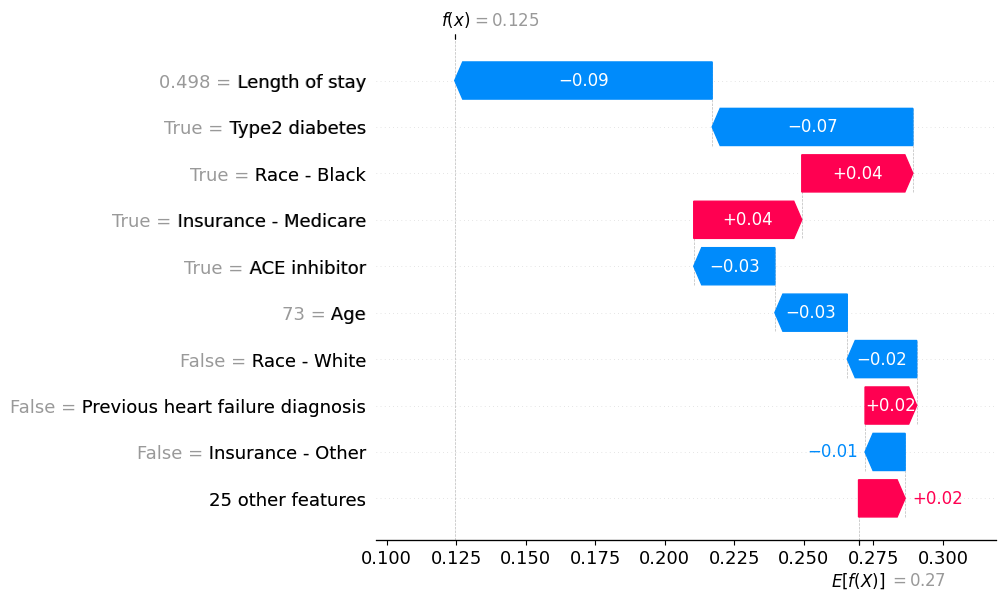

In [25]:
model = xgboost.XGBRegressor(enable_categorical = True).fit(X_dummies, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_dummies)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], )


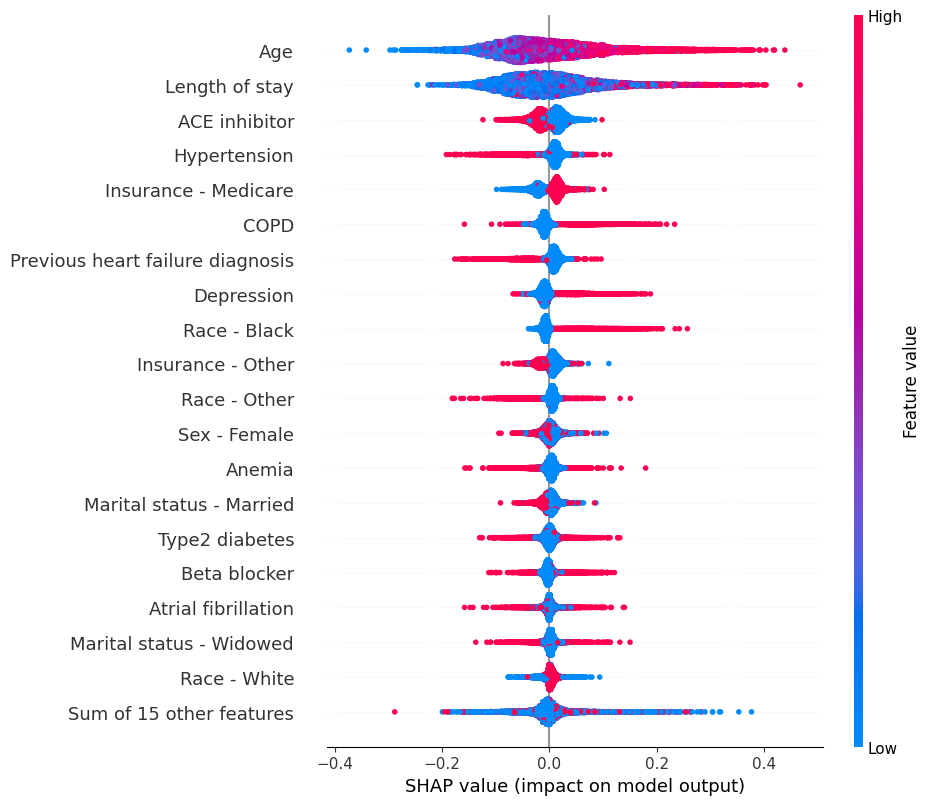

<Figure size 640x480 with 0 Axes>

In [27]:
shap.plots.beeswarm(shap_values, max_display=20)
import matplotlib.pyplot as plt
plt.savefig('shapley_beeswarm.png')